# Preprocessing data, i.e., transcript(s)

In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import re
import pandas as pd
from docx import Document
from datetime import datetime

def extract_title_info(file_name):
    # Extracting transcript number, DN & P present, and timestamp from the file name
    transcript_number_match = re.search(r'Transcript (\d+)', file_name)
    dn_p_present_match = re.search(r'\((DN\d+) & (P\d+)\)', file_name)
    timestamp_match = re.search(r'- (\d{2}-\d{2}-\d{4} \d{2}-\d{2}) -', file_name)

    if transcript_number_match and dn_p_present_match and timestamp_match:
        transcript_number = transcript_number_match.group(1)
        dn_present = dn_p_present_match.group(1)
        p_present = dn_p_present_match.group(2)
        timestamp = datetime.strptime(timestamp_match.group(1), '%d-%m-%Y %H-%M')
        return transcript_number, dn_present, p_present, timestamp
    else:
        print(f"File name format issue: {file_name}")
        return None, None, None, None

def extract_timestamp(date, time_str):
    try:
        datetime_str = f"{date} {time_str}"
        return datetime.strptime(datetime_str, '%d %B %Y %H:%M:%S')
    except ValueError as e:
        print(f"Timestamp format issue with date: {date} and time: {time_str} - {e}")
        return None

def process_docx(file_path, file_name):
    doc = Document(file_path)

    # Extract title and first line date
    if len(doc.paragraphs) < 2:
        print(f"File {file_path} does not have enough paragraphs.")
        return []

    date_line = doc.paragraphs[0].text
    date_match = re.search(r'Date: (.+)', date_line)

    if date_match:
        date = date_match.group(1)
    else:
        print(f"Date format issue in file: {file_path}")
        return []

    transcript_number, dn_present, p_present, initial_timestamp = extract_title_info(file_name)
    if not transcript_number or not dn_present or not p_present or not initial_timestamp:
        return []

    rows = []
    for para in doc.paragraphs[1:]:
        # Skip empty paragraphs
        if not para.text.strip():
            continue

        match = re.match(r'(\d{2}:\d{2}:\d{2})\s+([^:]+):\s+(.*)', para.text)
        if match:
            time_str, speaker, quote = match.groups()
            timestamp = extract_timestamp(date, time_str)
            if timestamp:
                rows.append([transcript_number, dn_present, p_present, timestamp, speaker, quote])
        else:
            print(f"Line format issue in file: {file_path} with line: {para.text}")

    return rows

def process_all_docs(directory):
    all_data = []
    files = [f for f in os.listdir(directory) if f.endswith('.docx')]

    for filename in files:
        file_path = os.path.join(directory, filename)
        all_data.extend(process_docx(file_path, filename))

    df = pd.DataFrame(all_data, columns=['Transcript number', 'District nurse present', 'Patient present', 'Timestamp', 'Speaker', 'Quote'])
    return df

# Assuming the current directory is where the docx files are uploaded
directory = '.'

# Process all DOCX files and create the DataFrame
df = process_all_docs(directory)

# Optionally, save it to a CSV file
df.to_csv('transcript-log.csv', index=False)

df

,Transcript number,District nurse present,Patient present,Timestamp,Speaker,Quote
0,26,DN03,P26,2023-12-07 08:05:00,DN03,"Zo, maar je hebt wel lekker geslapen?"
1,26,DN03,P26,2023-12-07 08:05:09,P26,Ik heb wel lekker geslapen.
2,26,DN03,P26,2023-12-07 08:05:10,DN03,Nou fijn.
3,26,DN03,P26,2023-12-07 08:05:14,P26,Maar ik ben nog moe.
4,26,DN03,P26,2023-12-07 08:05:15,DN03,"Ja en de uitslag gekregen, hè?"
...,...,...,...,...,...,...
6552,23,DN02,P23,2023-11-05 11:20:37,DN02,"Nee, maar dat is alleen maar fijn dat hè dat j..."
6553,23,DN02,P23,2023-11-05 11:20:42,P23,Het is voor jou ook de laatste dag?
6554,23,DN02,P23,2023-11-05 11:20:43,DN02,"Ja, ja hoor ja weet je. Ik heb hem gisteren no..."
6555,23,DN02,P23,2023-11-05 11:20:48,P23,Is het drie weken?


In [ ]:
from datetime import datetime

# Sort the DataFrame based on Transcript number and Timestamp
df = df.sort_values(by=['Transcript number', 'Timestamp'])

# Convert 'Timestamp' column to datetime with specified format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M:%S')

# Function to merge rows if conditions are met
def merge_rows(row1, row2):
    if row1['Speaker'].startswith('DN') and row2['Speaker'].startswith('P'):
        time_diff = (row2['Timestamp'] - row1['Timestamp']).total_seconds()
        if time_diff < 20:
            row1['Text'] = "Verpleegkundige: " + row1['Quote'] + "; " + "Patient: " + row2['Quote']
            return row1
    # If conditions not met, return None
    return None

# Initialize list for merged rows
merged_rows = []

# Initialize variable to store the previous row
prev_row = None

# Iterate over DataFrame rows
for index, row in df.iterrows():
    if prev_row is not None:
        merged_row = merge_rows(prev_row, row)
        if merged_row is not None:
            merged_rows.append(merged_row)
            prev_row = None
        else:
            # If conditions not met for merging, add 'Text' column to previous row and append to merged_rows
            if prev_row['Speaker'].startswith('P'):
                role = 'Patient'
            elif prev_row['Speaker'].startswith('DN'):
                role = 'Verpleegkundige'
            prev_row['Text'] = role + ": " + prev_row['Quote']
            merged_rows.append(prev_row)
            prev_row = row
    else:
        # If prev_row is None, set 'Text' column for the current row and update prev_row
        if row['Speaker'].startswith('P'):
            role = 'Patient'
        elif row['Speaker'].startswith('DN'):
            role = 'Verpleegkundige'
        row['Text'] = role + ": " + row['Quote']
        prev_row = row

# If prev_row is not None after iterating over all rows, add its 'Text' column
if prev_row is not None:
    if prev_row['Speaker'].startswith('P'):
        role = 'Patient'
    elif prev_row['Speaker'].startswith('DN'):
        role = 'Verpleegkundige'
    prev_row['Text'] = role + ": " + prev_row['Quote']
    merged_rows.append(prev_row)

# Convert the list of merged rows into a DataFrame
merged_df = pd.DataFrame(merged_rows)

# Reset index
merged_df = merged_df.reset_index(drop=True)

# Drop 'Speaker' and 'Quote' columns
merged_df = merged_df.drop(['Speaker', 'Quote'], axis=1)

# Display the merged DataFrame
merged_df

,Transcript number,District nurse present,Patient present,Timestamp,Text
0,1,DN01,P01,2023-09-12 08:48:00,"Verpleegkundige: Ja nou, daar gaan we weer. Ik..."
1,1,DN01,P01,2023-09-12 08:48:11,Verpleegkundige: Nou ga ik alvast naar boven. ...
2,1,DN01,P01,2023-09-12 08:48:24,"Verpleegkundige: Nee hoor, hij blijft gewoon b..."
3,1,DN01,P01,2023-09-12 08:48:29,"Verpleegkundige: Ja, wij doen gewoon ons ding ..."
4,1,DN01,P01,2023-09-12 08:48:53,Patient: Was het druk buiten?
...,...,...,...,...,...
3856,9,DN01,P09,2023-10-24 08:50:57,Verpleegkundige: Die heb je het meest van iede...
3857,9,DN01,P09,2023-10-24 08:51:10,Verpleegkundige: Zo alle administratie op orde...
3858,9,DN01,P09,2023-10-24 08:51:15,Verpleegkundige: Ik ben er ook maar heel af en...
3859,9,DN01,P09,2023-10-24 08:51:19,"Verpleegkundige: Nee, dat ben ik niet. Nee, ne..."


In [ ]:
# Convert 'Timestamp' column to datetime
merged_df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Group by 'Transcript number' and calculate required information
transcript_info = merged_df.groupby('Transcript number').agg(
    row_count=('Timestamp', 'count'),
    first_timestamp=('Timestamp', 'min'),
    last_timestamp=('Timestamp', 'max'),
    dn_present=('District nurse present', 'first')
).reset_index()

# Calculate the time difference between the first and last timestamps in hours:minutes:seconds format
transcript_info['duration'] = transcript_info['last_timestamp'] - transcript_info['first_timestamp']
transcript_info['duration'] = transcript_info['duration'].apply(lambda x: str(x).split()[-1])

# Sort by 'District nurse present' and then by 'Transcript number'
transcript_info = transcript_info.sort_values(by=['first_timestamp'])

transcript_info

,Transcript number,row_count,first_timestamp,last_timestamp,dn_present,duration
15,23,182,2023-09-12 08:48:00,2023-11-04 09:06:02,DN02,00:18:02
16,24,159,2023-09-12 08:53:02,2023-09-12 09:14:59,DN03,00:21:57
17,25,278,2023-09-12 09:15:02,2023-10-13 11:48:22,DN03,02:33:20
23,6,188,2023-09-12 09:35:00,2023-11-04 11:36:56,DN02,02:01:56
21,4,161,2023-09-12 10:34:00,2023-10-24 09:35:32,DN01,23:01:32
22,5,330,2023-09-12 10:38:09,2023-10-24 21:54:39,DN02,11:16:30
5,14,72,2023-10-13 08:41:00,2023-12-08 09:04:08,DN02,00:23:08
6,15,100,2023-10-13 08:44:42,2023-10-13 08:57:10,DN02,00:12:28
7,16,84,2023-10-13 08:57:17,2023-10-13 09:08:49,DN02,00:11:32
8,17,159,2023-10-13 09:08:51,2023-10-13 09:28:05,DN02,00:19:14


<ipython-input-6-4038d49db0fa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(transcript_info, x='row_count', y='dn_present', inner='stick', palette='Dark2')


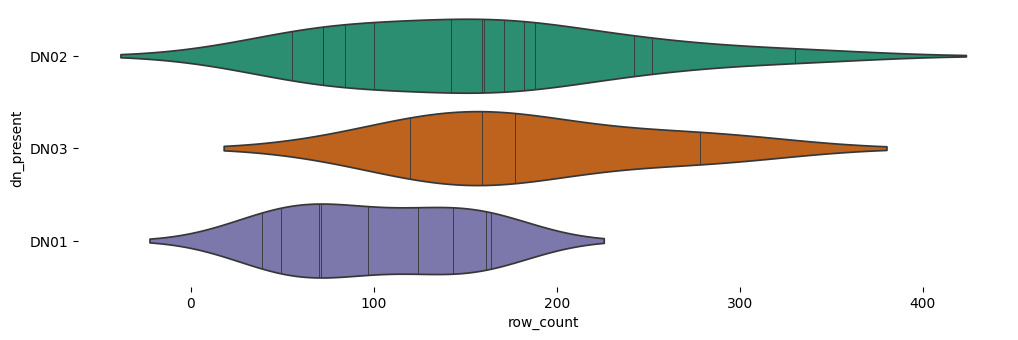

In [ ]:
# @title dn_present vs row_count

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(transcript_info['dn_present'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(transcript_info, x='row_count', y='dn_present', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Load the NIC.csv file into a DataFrame
try:
    nic_df = pd.read_csv('NIC.csv', sep=';', encoding='utf-8')
except UnicodeDecodeError:
    try:
        nic_df = pd.read_csv('NIC.csv', sep=';', encoding='latin1')
    except UnicodeDecodeError:
        nic_df = pd.read_csv('NIC.csv', sep=';', encoding='iso-8859-1')

# Combine two columns
# nic_df['Combined'] = nic_df['Interventie'] + ': ' + nic_df['Definitie']

nic_df

,Interventie,ENG,Class,Domain
0,"Aankleden, ondersteuning",Dressing,Self-care facilitation,Physiological: basic
1,Aanraken,Touch,Coping assistance,Behavioral
2,Aanwezig zijn,Presence,Coping assistance,Behavioral
3,Actief luisteren,Active Listening,Communication enhancement,Behavioral
4,Activiteitenbegeleiding,Activity Therapy,Behavior therapy,Behavioral
...,...,...,...,...
445,"Zuigreflex, bevordering",Nonnutritive Sucking,Childbearing Care,Family
446,Zuur-basebeleid,Acid-Base Management,Electrolyte and Acid-Base Management,Physiological: complex
447,"Zuur-basehuishouding, bewaking",Acid-Base Monitoring,Electrolyte and Acid-Base Management,Physiological: complex
448,Zuurstoftherapie,Oxygen Therapy,Respiratory Management,Physiological: complex


In [ ]:
# Filter the rows where df['Transcript number'] == 11
#df_subset = merged_df[df['Transcript number'] == "11"].copy()

df_subset = merged_df

df_subset

,Transcript number,District nurse present,Patient present,Timestamp,Text
0,24,DN03,P24,2023-12-07 08:05:00,Verpleegkundige: Goedemorgen. Hallo. Wat zegt ...
1,24,DN03,P24,2023-12-07 08:05:09,Patient: Ja.
2,24,DN03,P24,2023-12-07 08:05:10,Verpleegkundige: En vindt u het goed dat ik he...
3,24,DN03,P24,2023-12-07 08:05:14,Verpleegkundige: Ja. Dan wijs ik hem even de w...
4,24,DN03,P24,2023-12-07 08:05:15,"Verpleegkundige: Dat is goed, ja.; Patient: Ja..."
...,...,...,...,...,...
729,27,DN03,P27,2023-12-05 09:05:07,"Verpleegkundige: Ja, daarom. Nou leeg potje hi..."
730,27,DN03,P27,2023-12-05 09:05:08,"Verpleegkundige: Ja, dat heb ik al gedaan. Ik ..."
731,27,DN03,P27,2023-12-05 09:05:13,"Verpleegkundige: Dat is goed, zal ik doen.; Pa..."
732,27,DN03,P27,2023-12-05 09:05:25,Verpleegkundige: Ja.


# Classifying the texts

In [ ]:
!pip install scikit-llm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
from skllm.config import SKLLMConfig

SKLLMConfig.set_openai_key("enter-key")
SKLLMConfig.set_openai_org("enter-org")

In [ ]:
from skllm.models.gpt.classification.zero_shot import ZeroShotGPTClassifier

# Define the labels for classification
labels = nic_df['Interventie'].tolist()

# Set up the ZeroShotGPTClassifier
clf = ZeroShotGPTClassifier(model="gpt-4o", default_label="null")
clf.fit(None, labels)

# Apply classification to each quote and add result to new column 'Intervention'
df_subset['Intervention'] = clf.predict(df_subset['Text'].tolist())

# Display the subset DataFrame
df_subset

100%|██████████| 734/734 [11:47<00:00,  1.04it/s]


,Transcript number,District nurse present,Patient present,Timestamp,Text,Intervention,ENG,Class,Domain
0,24,DN03,P24,2023-12-07 08:05:00,Verpleegkundige: Goedemorgen. Hallo. Wat zegt ...,Actief luisteren,Active Listening,Communication enhancement,Behavioral
1,24,DN03,P24,2023-12-07 08:05:09,Patient: Ja.,Actief luisteren,Active Listening,Communication enhancement,Behavioral
2,24,DN03,P24,2023-12-07 08:05:10,Verpleegkundige: En vindt u het goed dat ik he...,Actief luisteren,Active Listening,Communication enhancement,Behavioral
3,24,DN03,P24,2023-12-07 08:05:14,Verpleegkundige: Ja. Dan wijs ik hem even de w...,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
4,24,DN03,P24,2023-12-07 08:05:15,"Verpleegkundige: Dat is goed, ja.; Patient: Ja...",Actief luisteren,Active Listening,Communication enhancement,Behavioral
...,...,...,...,...,...,...,...,...,...
729,27,DN03,P27,2023-12-05 09:05:07,"Verpleegkundige: Ja, daarom. Nou leeg potje hi...","Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
730,27,DN03,P27,2023-12-05 09:05:08,"Verpleegkundige: Ja, dat heb ik al gedaan. Ik ...","Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
731,27,DN03,P27,2023-12-05 09:05:13,"Verpleegkundige: Dat is goed, zal ik doen.; Pa...",Actief luisteren,Active Listening,Communication enhancement,Behavioral
732,27,DN03,P27,2023-12-05 09:05:25,Verpleegkundige: Ja.,Actief luisteren,Active Listening,Communication enhancement,Behavioral


In [ ]:
# List of unique values in df_subset['Intervention']
intervention_subset_values = df_subset['Intervention'].unique()

# List of unique values in nic_df['Interventie']
intervention_nic_values = nic_df['Interventie'].unique()

# Check if all values in df_subset['Intervention'] exist in nic_df['Interventie']
missing_values = [value for value in intervention_subset_values if value not in intervention_nic_values]

if missing_values:
    print("Values not found in nic_df['Interventie']:", missing_values)
else:
    print("No hallucination")

No hallucination


In [ ]:
# Create dictionaries from nic_df
intervention_to_eng = dict(zip(nic_df['Interventie'], nic_df['ENG']))
intervention_to_class = dict(zip(nic_df['Interventie'], nic_df['Class']))
intervention_to_domain = dict(zip(nic_df['Interventie'], nic_df['Domain']))

# Map the 'Intervention' column in df_subset to the 'ENG', 'Class', and 'Domain' values
df_subset['ENG'] = df_subset['Intervention'].map(intervention_to_eng)
df_subset['Class'] = df_subset['Intervention'].map(intervention_to_class)
df_subset['Domain'] = df_subset['Intervention'].map(intervention_to_domain)

# Optionally, save it to a CSV file
df_subset.to_csv('classification.csv', index=False)

# Display the result
df_subset

,Transcript number,District nurse present,Patient present,Timestamp,Text,Intervention,ENG,Class,Domain
0,24,DN03,P24,2023-12-07 08:05:00,Verpleegkundige: Goedemorgen. Hallo. Wat zegt ...,Actief luisteren,Active Listening,Communication enhancement,Behavioral
1,24,DN03,P24,2023-12-07 08:05:09,Patient: Ja.,Actief luisteren,Active Listening,Communication enhancement,Behavioral
2,24,DN03,P24,2023-12-07 08:05:10,Verpleegkundige: En vindt u het goed dat ik he...,Actief luisteren,Active Listening,Communication enhancement,Behavioral
3,24,DN03,P24,2023-12-07 08:05:14,Verpleegkundige: Ja. Dan wijs ik hem even de w...,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
4,24,DN03,P24,2023-12-07 08:05:15,"Verpleegkundige: Dat is goed, ja.; Patient: Ja...",Actief luisteren,Active Listening,Communication enhancement,Behavioral
...,...,...,...,...,...,...,...,...,...
729,27,DN03,P27,2023-12-05 09:05:07,"Verpleegkundige: Ja, daarom. Nou leeg potje hi...","Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
730,27,DN03,P27,2023-12-05 09:05:08,"Verpleegkundige: Ja, dat heb ik al gedaan. Ik ...","Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic
731,27,DN03,P27,2023-12-05 09:05:13,"Verpleegkundige: Dat is goed, zal ik doen.; Pa...",Actief luisteren,Active Listening,Communication enhancement,Behavioral
732,27,DN03,P27,2023-12-05 09:05:25,Verpleegkundige: Ja.,Actief luisteren,Active Listening,Communication enhancement,Behavioral


# Postprocessing individual logs

In [ ]:
import glob

# Define the path to your CSV files that start with 'T'
path = 'T*.csv'  # Assuming the script is in the same directory as the CSV files

# Read all CSV files starting with 'T'
all_files = glob.glob(path)

# Initialize an empty dictionary to hold DataFrames for each version
dfs = {'R1': [], 'R2': [], 'R3': []}

# Loop through each file and read into the appropriate list in the dictionary
for file in all_files:
    if '_R1' in file:
        dfs['R1'].append(pd.read_csv(file))
    elif '_R2' in file:
        dfs['R2'].append(pd.read_csv(file))
    elif '_R3' in file:
        dfs['R3'].append(pd.read_csv(file))

# Concatenate DataFrames for each version
df_R1 = pd.concat(dfs['R1'], ignore_index=True)
df_R2 = pd.concat(dfs['R2'], ignore_index=True)
df_R3 = pd.concat(dfs['R3'], ignore_index=True)

# Ensure the first five columns are the same in each DataFrame and set them as the index for merging
key_columns = df_R1.columns[:5]

df_R1 = df_R1.set_index(list(key_columns))
df_R2 = df_R2.set_index(list(key_columns))
df_R3 = df_R3.set_index(list(key_columns))

# Select the relevant columns from each DataFrame and rename them to include version suffixes
df_R1 = df_R1[['Intervention', 'ENG', 'Class', 'Domain']].rename(columns={
    'Intervention': 'Intervention_R1',
    'ENG': 'ENG_R1',
    'Class': 'Class_R1',
    'Domain': 'Domain_R1'
})
df_R2 = df_R2[['Intervention', 'ENG', 'Class', 'Domain']].rename(columns={
    'Intervention': 'Intervention_R2',
    'ENG': 'ENG_R2',
    'Class': 'Class_R2',
    'Domain': 'Domain_R2'
})
df_R3 = df_R3[['Intervention', 'ENG', 'Class', 'Domain']].rename(columns={
    'Intervention': 'Intervention_R3',
    'ENG': 'ENG_R3',
    'Class': 'Class_R3',
    'Domain': 'Domain_R3'
})

# Merge the DataFrames on the key columns
merged_df = df_R1.join(df_R2, how='outer').join(df_R3, how='outer')

# Reset the index to turn the key columns back into regular columns
merged_df = merged_df.reset_index()

# Define a function to check agreement and store final values
def check_agreement(row):
    final_values = {}
    intervention_values = [row['Intervention_R1'], row['Intervention_R2'], row['Intervention_R3']]
    unique_intervention_values = set(intervention_values)

    if len(unique_intervention_values) == 1:
        # All three values are the same
        agreement = 3
        final_values['Intervention_final'] = intervention_values[0]
    elif len(unique_intervention_values) == 2:
        # Two out of three values are the same
        most_common_value = max(set(intervention_values), key=intervention_values.count)
        agreement = 2
        final_values['Intervention_final'] = most_common_value
    else:
        # All three values are different
        agreement = 1
        final_values['Intervention_final'] = None

    # For ENG, Class, and Domain, use the value from the most common Intervention match
    if agreement > 1:
        for column in ['ENG', 'Class', 'Domain']:
            column_values = [row[f'{column}_R1'], row[f'{column}_R2'], row[f'{column}_R3']]
            final_values[f'{column}_final'] = max(set(column_values), key=column_values.count)
    else:
        for column in ['ENG', 'Class', 'Domain']:
            final_values[f'{column}_final'] = None

    final_values['Agreement'] = agreement
    return pd.Series(final_values)

# Apply the function to each row
agreement_df = merged_df.apply(check_agreement, axis=1)

# Merge the new columns into the original DataFrame
final_df = pd.concat([merged_df, agreement_df], axis=1)

# Save the final merged DataFrame to a CSV file (optional)
final_df.to_csv('merged_output_with_agreement.csv', index=False)

# Display the first few rows of the final DataFrame
final_df

,Transcript number,District nurse present,Patient present,Timestamp,Text,Intervention_R1,ENG_R1,Class_R1,Domain_R1,Intervention_R2,...,Domain_R2,Intervention_R3,ENG_R3,Class_R3,Domain_R3,Intervention_final,ENG_final,Class_final,Domain_final,Agreement
0,1,DN01,P01,2023-09-12 08:48:00,"Verpleegkundige: Ja nou, daar gaan we weer. Ik...",Voorlichting: procedure/behandeling,Teaching: Procedure/Treatment,Health education,Behavioral,Voorlichting: procedure/behandeling,...,Behavioral,Voorlichting: procedure/behandeling,Teaching: Procedure/Treatment,Health education,Behavioral,Voorlichting: procedure/behandeling,Teaching: Procedure/Treatment,Health education,Behavioral,3.0
1,1,DN01,P01,2023-09-12 08:48:10,Verpleegkundige: Nou ga ik alvast naar boven. ...,Aanwezig zijn,Presence,Coping assistance,Behavioral,Aanwezig zijn,...,Behavioral,Aanwezig zijn,Presence,Coping assistance,Behavioral,Aanwezig zijn,Presence,Coping assistance,Behavioral,3.0
2,1,DN01,P01,2023-09-12 08:48:11,"Verpleegkundige: Nee hoor, hij blijft gewoon b...",Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,...,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,3.0
3,1,DN01,P01,2023-09-12 08:48:15,"Verpleegkundige: Ja, wij doen gewoon ons ding ...",Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,...,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,3.0
4,1,DN01,P01,2023-09-12 08:48:24,Patient: Was het druk buiten?,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,...,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,27,DN03,P27,2023-12-05 09:05:07,"Verpleegkundige: Ja, daarom. Nou leeg potje hi...",Actief luisteren,Active Listening,Communication enhancement,Behavioral,"Persoonlijke verzorging, ondersteuning toiletgang",...,Physiological: basic,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic,2.0
3857,27,DN03,P27,2023-12-05 09:05:08,"Verpleegkundige: Ja, dat heb ik al gedaan. Ik ...","Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic,"Persoonlijke verzorging, ondersteuning toiletgang",...,Physiological: basic,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic,"Persoonlijke verzorging, ondersteuning toiletgang",Self-Care Assistance: Toileting,Elimination management,Physiological: basic,3.0
3858,27,DN03,P27,2023-12-05 09:05:13,"Verpleegkundige: Dat is goed, zal ik doen.; Pa...",Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,...,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,3.0
3859,27,DN03,P27,2023-12-05 09:05:25,Verpleegkundige: Ja.,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,...,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,Actief luisteren,Active Listening,Communication enhancement,Behavioral,3.0
